In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
%%capture
!pip install albumentations==1.3.0
!pip install torchvision==0.15.1
!pip install torch==2.0.0

# Librerie

In [1]:
import re, sys, glob, time, os, math, random, shutil
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tqdm
from matplotlib import pyplot as plt

from PIL import Image
import cv2 as cv

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import torch
import torch.nn as nn
import torchvision
from torchvision import models
from torch.utils.data import Dataset, DataLoader
from torch.cuda.amp import autocast, GradScaler

from sklearn.preprocessing import *
from sklearn.metrics import *
from sklearn.model_selection import *

import tensorflow as tf

torch.__version__, torchvision.__version__, A.__version__

('2.0.0+cu118', '0.15.1+cu118', '1.2.1')

# Immagini

  0%|          | 0/7349 [00:00<?, ?it/s]

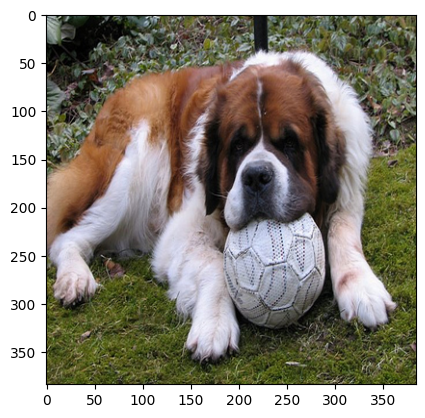

label: saint_bernard


In [2]:
def set_seed(seed=42):
  np.random.seed(seed)
  random.seed(seed)
  torch.manual_seed(seed)
  torch.cuda.manual_seed(seed)
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  os.environ['PYTHONHASHSEED'] = str(seed)

def create_dataset(dim1, dim2):
  folderT = os.listdir("/root/.keras/datasets/images/")
  folderT.sort()
  f = pd.concat([
      pd.read_csv("/root/.keras/datasets/annotations/test.txt", sep=" ", header=None),
      pd.read_csv("/root/.keras/datasets/annotations/trainval.txt", sep=" ", header=None)
      ])
  # f = f[f[2] == 1][0].tolist() # 1 only cat, 2 only dog
  f = f[0].tolist()  # cat + dog
  f.sort()
  image = []
  label = []
  for i in tqdm(f):
    for j in folderT:
      if i == j[:-4]:
        try:
          im = Image.open("/root/.keras/datasets/images/"+j)
          im = np.array(im.resize((dim1, dim2)))
          if im.shape == (dim1, dim2, 3):
            image.append(im)
            label.append("_".join(i.split("_")[:-1]))
        except Image.UnidentifiedImageError:
          continue
  return np.array(image), np.array(label)

path_to_images = tf.keras.utils.get_file("images", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz", untar=True)
path_to_annotations = tf.keras.utils.get_file("annotations", "http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz", untar=True)

dim = 384
X_train, y_train = create_dataset(dim, dim)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)
X_train.shape, y_train.shape, X_test.shape, y_test.shape

plt.imshow(X_train[0])
plt.show()
print("label:",y_train[0])

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)
np.save('/content/drive/MyDrive/Colab Notebooks/Telegram - Cat Dog Classification/classes_v2.npy', le.classes_)

# Model

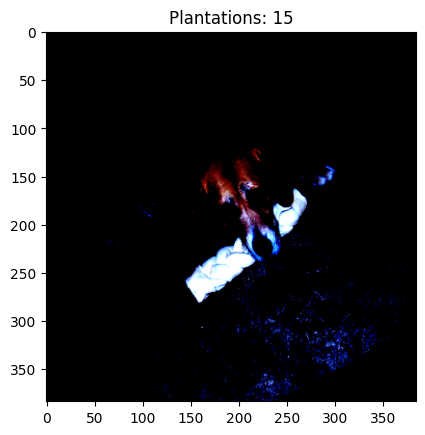

In [79]:
class cat_vs_dog(Dataset):
  def __init__(self, images, labels=None, transforms=None, train=True):
    super().__init__()
    self.images = images
    self.labels = labels
    self.train = train
    self.transforms = transforms

  def __getitem__(self, idx: int):
    image = self.images[idx]

    if self.transforms:
      image = self.transforms(image=image)

    if self.train is True:
      label = torch.Tensor([self.labels[idx]]).type(torch.long) 
      return image['image'], label
    else:
      return image['image']

  def __len__(self) -> int:
    return len(self.images)

def train_transform():
  return A.Compose([
      A.HorizontalFlip(p=0.5),
      A.VerticalFlip(p=0.5),
      A.Transpose(p=0.5),
      A.Rotate(limit=45, border_mode=cv.BORDER_CONSTANT, mask_value=0, p=0.5),
      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
      A.OneOf([
          A.MotionBlur(blur_limit=3, p=0.5),
          A.MedianBlur(blur_limit=3, p=0.5),
          A.Blur(blur_limit=3, p=0.5),
          ], p=0.25),
      A.GaussNoise(0.2),
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
      ToTensorV2(p=1.0),
      ])

def valid_transform():
  return A.Compose([
      A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
      ToTensorV2(p=1.0)
      ])

train_dataset = cat_vs_dog(X_train, y_train, train_transform(), train=True)

random_image = random.randint(0, len(X_train) - 1)
image_label = train_dataset[random_image]
image = image_label[0].permute(1, 2, 0).numpy()
label = int(image_label[1].numpy()[0])
plt.title(f'Plantations: {label}')
plt.imshow(image)
plt.show()

In [14]:
class Net(nn.Module):
  def __init__(self, name, weights=None, n_classes=1):
    super(Net, self).__init__()
    if name == 'efficientnet_v2_s':
      self.model = models.efficientnet_v2_s(weights=weights)
      self.model.classifier[1] = nn.Linear(self.model.classifier[1].in_features, n_classes)

  def forward(self, x):
    x = self.model(x)
    return x

In [82]:
loss = nn.CrossEntropyLoss(label_smoothing=0.1)

def loss_fn(pred, true):
  return loss(pred, true)

def train_fn(data_loader, model, optimizer, device, scheduler, amp=False, disable=True):
  model.train()
  scaler = torch.cuda.amp.GradScaler(enabled=amp)
  tk0 = tqdm(data_loader, total=len(data_loader), disable=disable)
  train_loss = []
  for step, (images, label) in enumerate(tk0):

    images = images.to(device).float()
    label = label.to(device).squeeze()

    optimizer.zero_grad()
    with autocast(enabled=amp):
      out = model(images)
      loss = loss_fn(out, label)

    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    if scheduler is not None:
      scheduler.step()

    tk0.set_postfix(loss=loss.detach().cpu().numpy())
    train_loss.append(loss.detach().cpu().numpy())
  return np.mean(train_loss)

def eval_fn(data_loader, model, device, disable=True):
  model.eval()
  valid_loss = []
  preds_out = []
  with torch.no_grad():
    tk0 = tqdm(data_loader, total=len(data_loader), disable=disable)
    for step, (images, label) in enumerate(tk0):

      images = images.to(device).float()
      label = label.to(device).squeeze()

      out = model(images)
      loss = loss_fn(out, label)

      tk0.set_postfix(loss=loss.detach().cpu().numpy())
      valid_loss.append(loss.detach().cpu().numpy())
      preds_out.append(out.detach().softmax(1).cpu().numpy())
  return np.mean(valid_loss), np.concatenate(preds_out, axis=0)

def test_fn(data_loader, model, device):
  model.eval()
  pred = []
  with torch.no_grad():
    for images in data_loader:
      images = images.to(device).float()
      out = model(images)
      pred.append(out.detach().softmax(1).cpu().numpy())
  return np.concatenate(pred, axis=0)

In [65]:
name = "efficientnet_v2_s"
weights='IMAGENET1K_V1'
num_epochs = 10
bs = 16

set_seed()

train_data_loader = DataLoader(cat_vs_dog(X_train, y_train, train_transform()), shuffle=True, batch_size=bs, num_workers=2)
valid_data_loader = DataLoader(cat_vs_dog(X_test, y_test, valid_transform()), shuffle=False, batch_size=bs, num_workers=2)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = Net(name, weights=weights, n_classes=len(np.unique(y_train)))
model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-3)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=len(train_data_loader)* 10, eta_min=1e-5, verbose=False)

save_path_fold = f'/content/{name}.pth'
best_loss = 0
for epoch in range(num_epochs):
  train_loss = train_fn(train_data_loader, model, optimizer, device, lr_scheduler, amp=True, disable=False)
  valid_loss, valid_pred_out = eval_fn(valid_data_loader, model, device, disable=True)
  valid_loss = f1_score(y_test, np.argmax(valid_pred_out, -1), average='micro')

  if valid_loss > best_loss:
    best_loss = valid_loss
    torch.save(model.state_dict(), save_path_fold)
    print('| EPOCH {}| TRAIN LOSS {}| VALID F1 {}|'.format(epoch + 1, train_loss, valid_loss))

  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 1| TRAIN LOSS 2.0247962474823| VALID F1 0.6891156462585034|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 2| TRAIN LOSS 1.494792103767395| VALID F1 0.8231292517006803|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 3| TRAIN LOSS 1.2976959943771362| VALID F1 0.8272108843537415|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 4| TRAIN LOSS 1.1587952375411987| VALID F1 0.8605442176870749|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 5| TRAIN LOSS 1.032689094543457| VALID F1 0.8816326530612245|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 6| TRAIN LOSS 0.9290615320205688| VALID F1 0.8979591836734694|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 7| TRAIN LOSS 0.8384885191917419| VALID F1 0.9115646258503401|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 8| TRAIN LOSS 0.7838283777236938| VALID F1 0.9142857142857143|


  0%|          | 0/368 [00:00<?, ?it/s]

| EPOCH 9| TRAIN LOSS 0.7510748505592346| VALID F1 0.9204081632653062|


  0%|          | 0/368 [00:00<?, ?it/s]

In [89]:
model = Net(name, weights=weights, n_classes=len(np.unique(y_train)))
model.load_state_dict(torch.load(save_path_fold))
model.to(device)

test_data_loader = DataLoader(cat_vs_dog(X_test, transforms=valid_transform(), train=False), shuffle=False, batch_size=bs, num_workers=2)
pred = test_fn(test_data_loader, model, device)
print(classification_report(le.inverse_transform(y_test), le.inverse_transform(pred.argmax(-1)), digits=4))

                            precision    recall  f1-score   support

                Abyssinian     0.9487    0.9487    0.9487        39
                    Bengal     0.8750    0.8750    0.8750        40
                    Birman     0.8333    0.8750    0.8537        40
                    Bombay     0.9487    1.0000    0.9737        37
         British_Shorthair     0.9211    0.8750    0.8974        40
              Egyptian_Mau     0.9444    0.8947    0.9189        38
                Maine_Coon     0.9487    0.9250    0.9367        40
                   Persian     0.9302    1.0000    0.9639        40
                   Ragdoll     0.9706    0.8250    0.8919        40
              Russian_Blue     0.9000    0.9000    0.9000        40
                   Siamese     0.9070    0.9750    0.9398        40
                    Sphynx     0.9750    0.9750    0.9750        40
          american_bulldog     0.7234    0.8500    0.7816        40
 american_pit_bull_terrier     0.9000    0.6750

In [90]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Telegram - Cat Dog Classification/efficientnet_v2_s_cat_vs_dog.pth")

# Risultati

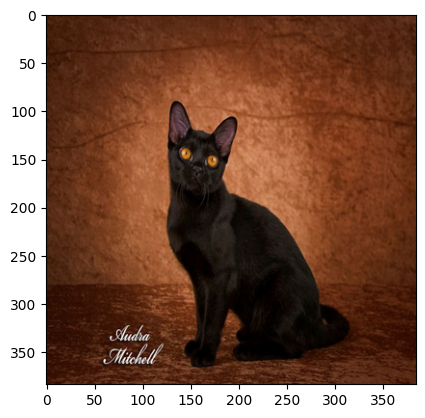

label: Bombay
label pred: Bombay


In [100]:
num = 3
plt.imshow(X_test[num])
plt.show()
print("label:", le.inverse_transform([y_test[num]])[0])

img_test = X_test[num].reshape(1, dim, dim, 3)
predict_data_loader = DataLoader(cat_vs_dog(img_test, transforms=valid_transform(), train=False), shuffle=False, batch_size=bs, num_workers=2)

pred = test_fn(predict_data_loader, model, device)
pred = le.inverse_transform([pred.argmax()])[0]
print("label pred:", pred)